<a href="https://colab.research.google.com/github/MANDOJU1/Text-Mining/blob/main/10_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98%E2%91%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 텍스트 머신러닝 단계

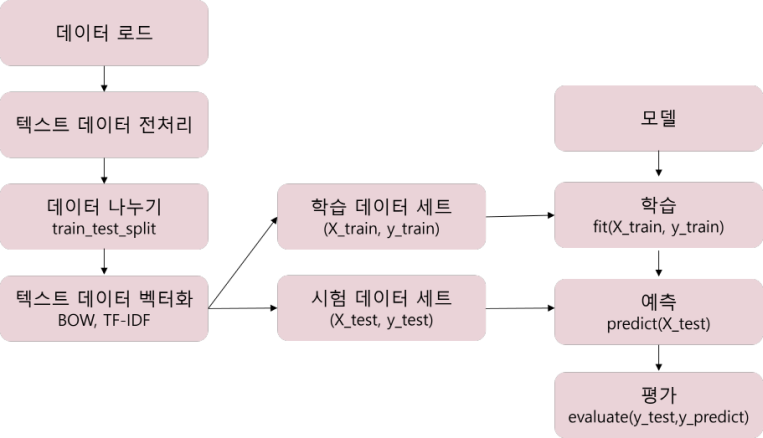




In [ ]:
!pip install koreanize_matplotlib
!pip install konlpy --upgrade
!pip install tqdm --upgrade

!pip install wordcloud

!pip install pecab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 40.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 14.7 MB/s eta 0:00:00
  Created wheel for pecab: filename=pecab-1.0.8-py3-none-any.whl size=26646664 sha256=9a5307f2976e2e9ff8234f32fc98d987a73b2131bd82410bb985f11a6509b815
  Stored in directory: /root/.cache/pip/wheels/5c/6f/b4/ab61b8863d7d8b1409def8ae31adcaa089fa91b8d022ec309d
Successfully built pecab


In [ ]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
import koreanize_matplotlib

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. 데이터 로드

- https://dacon.io/competitions/official/235747/data
  - train_data.csv, test_data.csv, sample_submission.csv, topic_dict.csv
  - 뉴스 데이터는 분류형 데이터에 속함

In [ ]:
# 학습 / 시험 데이터 세트를 읽어서 train 과 test 변수에 입력

train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/텍스트마이닝/data/train_data.csv")
test  = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/텍스트마이닝/data/test_data.csv")

train.shape, test.shape

((45654, 3), (9131, 2))

In [ ]:
# 토픽 불러오기

topic = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/텍스트마이닝/data/topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [ ]:
# 정답이 레이블링 되어 있는 연습문제

train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [ ]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [ ]:
train['topic_idx'].value_counts()

topic_idx
4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: count, dtype: int64

In [ ]:
topic.index

RangeIndex(start=0, stop=7, step=1)

## 2. 텍스트 데이터 전처리



### 1) 문자 길이, 단어의 등장 빈도 확인 후 시각화 : 데이터 특성 파악

In [ ]:
# df 합치기 - concat(), merge()

raw = pd.concat([train, test])
raw.shape

(54785, 3)

In [ ]:
raw.tail()

,index,title,topic_idx
9126,54780,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여,NaN
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,NaN
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개,NaN
9129,54783,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계,NaN
9130,54784,유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구,NaN


- test 데이터 셋에는 topic_idx 가 없었기 때문에 NaN 이 나오는 것을 볼 수 있음

In [ ]:
df = raw.merge(topic, how="left")
df.shape

(54785, 4)

### 정답값 빈도수

In [ ]:
# topic_idx : NaN 값이 들어있기 때문에 float 형태로 idx 값 나옴

df['topic_idx'].value_counts()

topic_idx
4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: count, dtype: int64

In [ ]:
df['topic'].value_counts()

topic
세계      7629
사회      7362
스포츠     6933
정치      6751
경제      6222
생활문화    5933
IT과학    4824
Name: count, dtype: int64

In [ ]:
df['topic'].value_counts(normalize=True)

topic
세계      0.167105
사회      0.161256
스포츠     0.151860
정치      0.147873
경제      0.136286
생활문화    0.129956
IT과학    0.105664
Name: proportion, dtype: float64

<Axes: xlabel='count', ylabel='topic'>

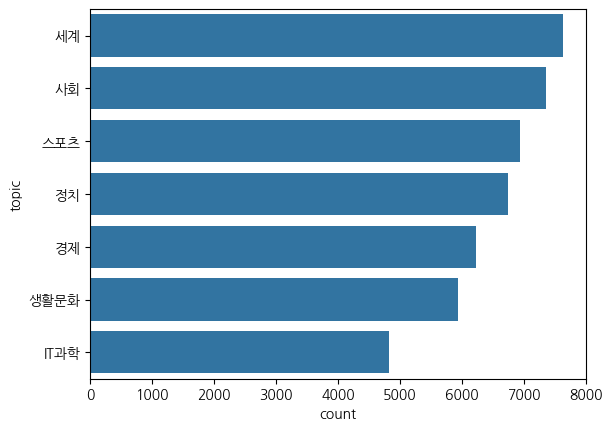

In [ ]:
sns.countplot(data=df, y="topic", order=df['topic'].value_counts().index)

- 뉴스 기사의 토픽별로 '세계'에 해당하는 문서가 가장 많고, IT 과학에 해당하는 문서가 가장 적음
- 데이터의 불균형을 어떻게 처리할 것인가?

### 문자 길이 및 글자의 빈도와 단어수 빈도수
> 문자 길이 확인
  - 문자 길이가 긴 텍스트는 의미를 학습하기에 충분하고, 길이가 짧으면 불충분하기 때문에 확인 필요
  - 혹은 학습완료 후 성능 향상을 위한 계획을 세울 때 단어 빈도 또는 문자 길이 등을 유용하게 사용

> 글자의 빈도와 단어의 빈도수 확인 단계
  - ① 음절 길이(len)와 단어 빈도(word_count)등의 빈도수를 다음과 같이 데이터 프레임에 넣는다
  - ② len()으로 낱글자의 길이 세기
  - ③ split()을 사용해 공백을 기준으로 한 어절(토큰)의 길이 세기
  - ④ 중복 없이 등장하는 어절의 길이는 집합형인 set 사용

> split()을 사용해 공백을 기준으로 한 어절(토큰)의 길이 세기 예시
 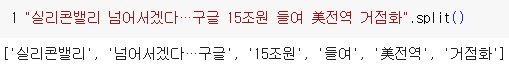

In [ ]:
# title 길이
df['len'] = df['title'].map(lambda x:len(x))

In [ ]:
# word_count 길이 : 공백기준

df['word_count'] = df['title'].map(lambda x:len(x.split()))

In [ ]:
# unique_word_count : 공백으로 잘라진 단어 중 unique 개수

df['unique_word_count'] = df['title'].map(lambda x:len(np.unique(x.split())))

In [ ]:
df.head()

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계,24,5,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계,30,6,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계,32,7,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7


> **시각화**

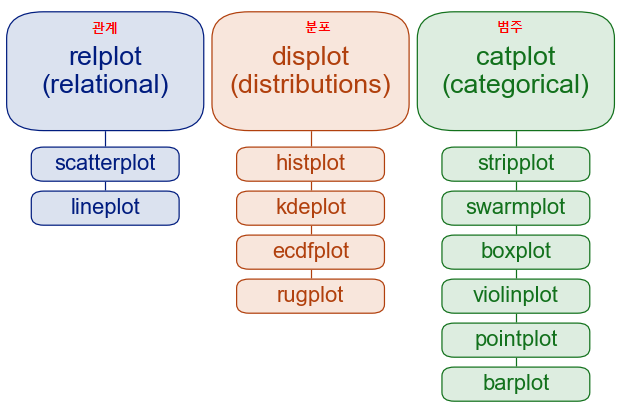

https://seaborn.pydata.org/tutorial/function_overview.html

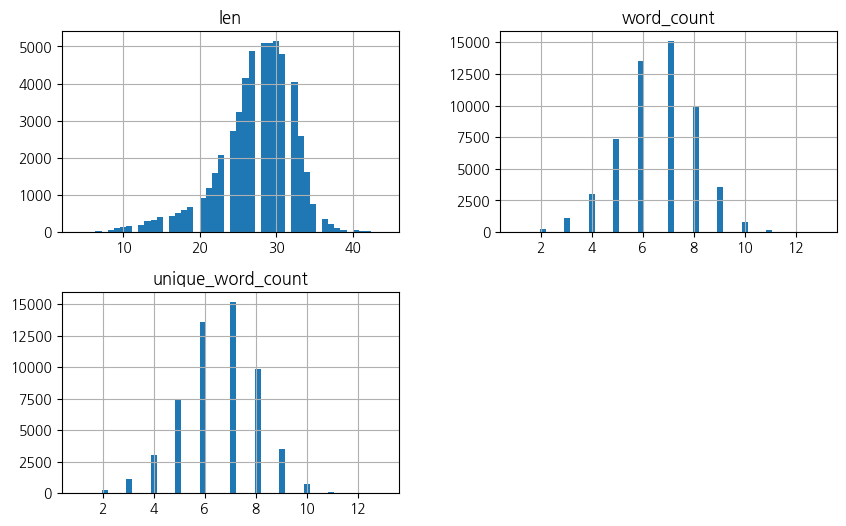

In [ ]:
df.iloc[:, -3:].hist(bins=50, figsize=(10,6));

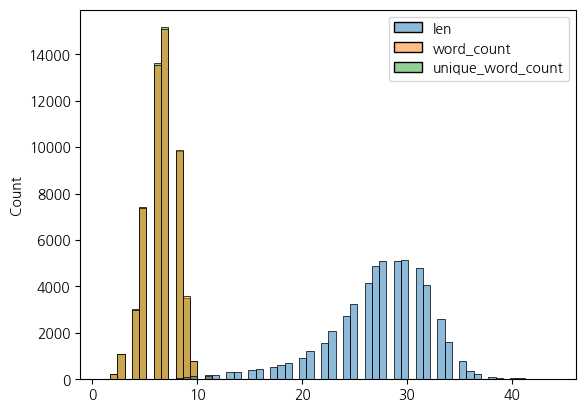

In [ ]:
sns.histplot(df.iloc[:, -3:]);

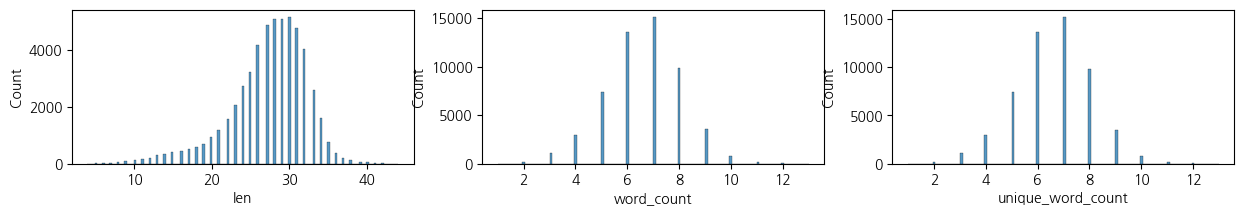

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,2))
sns.histplot(df["len"], ax = axes[0]);
sns.histplot(df["word_count"], ax = axes[1]);
sns.histplot(df["unique_word_count"], ax = axes[2]);

- 연합뉴스 기사에서 제목만 추출 : 20~30 개 사이에 빈도수가 몰려 있음
- 단어 수도 6~8 개 내외

In [ ]:
df[['len','word_count','unique_word_count']].describe()

,len,word_count,unique_word_count
count,54785.000000,54785.000000,54785.000000
mean,27.318846,6.587880,6.576198
std,4.947738,1.471852,1.465320
min,4.000000,1.000000,1.000000
25%,25.000000,6.000000,6.000000
50%,28.000000,7.000000,7.000000
75%,31.000000,8.000000,8.000000
max,44.000000,13.000000,13.000000


> 토픽별 글자와 단어의 빈도 확인

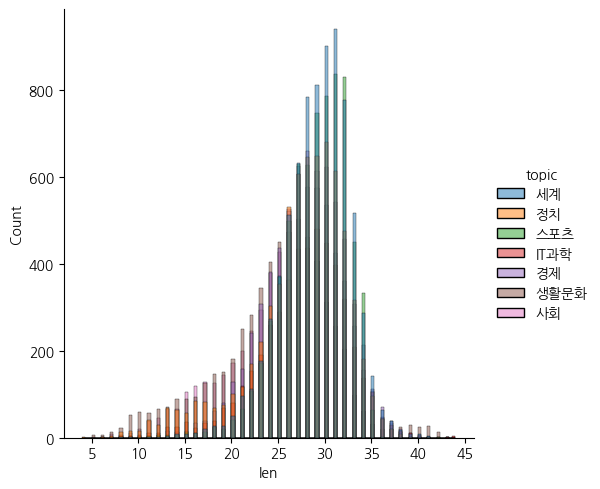

In [ ]:
sns.displot(data=df, x="len", hue="topic", kind="hist");

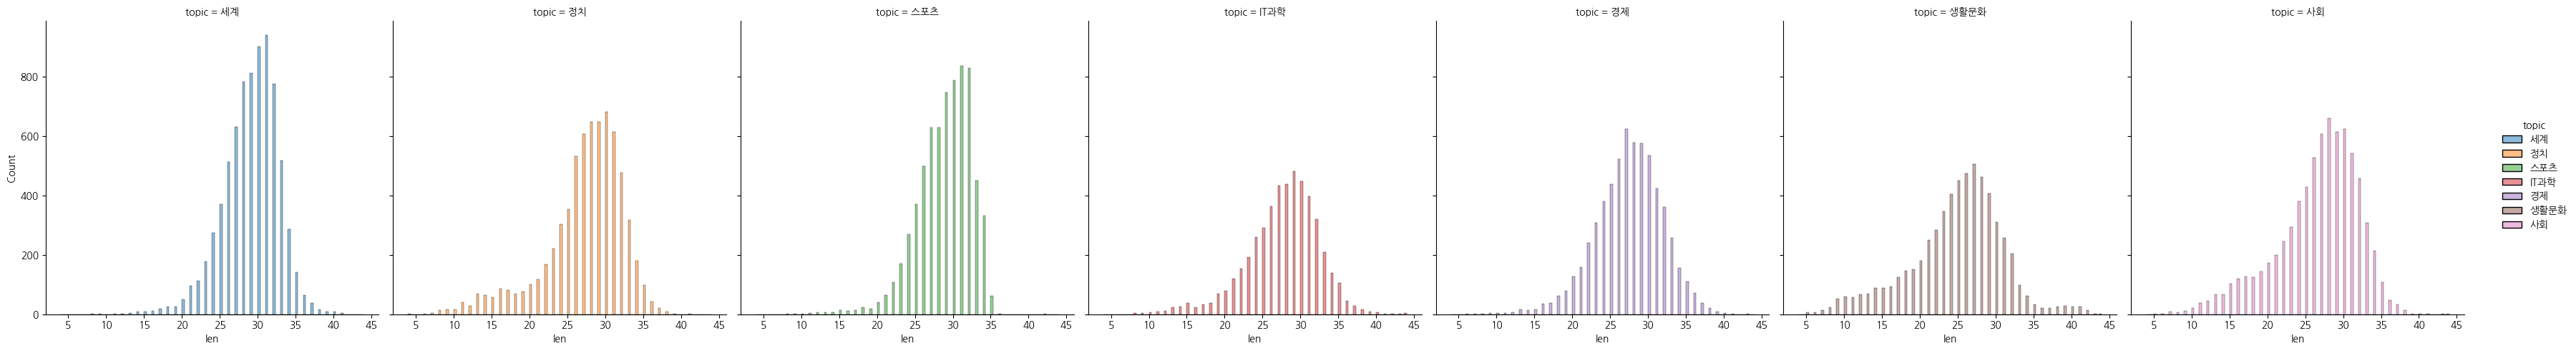

In [ ]:
sns.displot(data=df, x="len", hue="topic", kind="hist", col="topic");

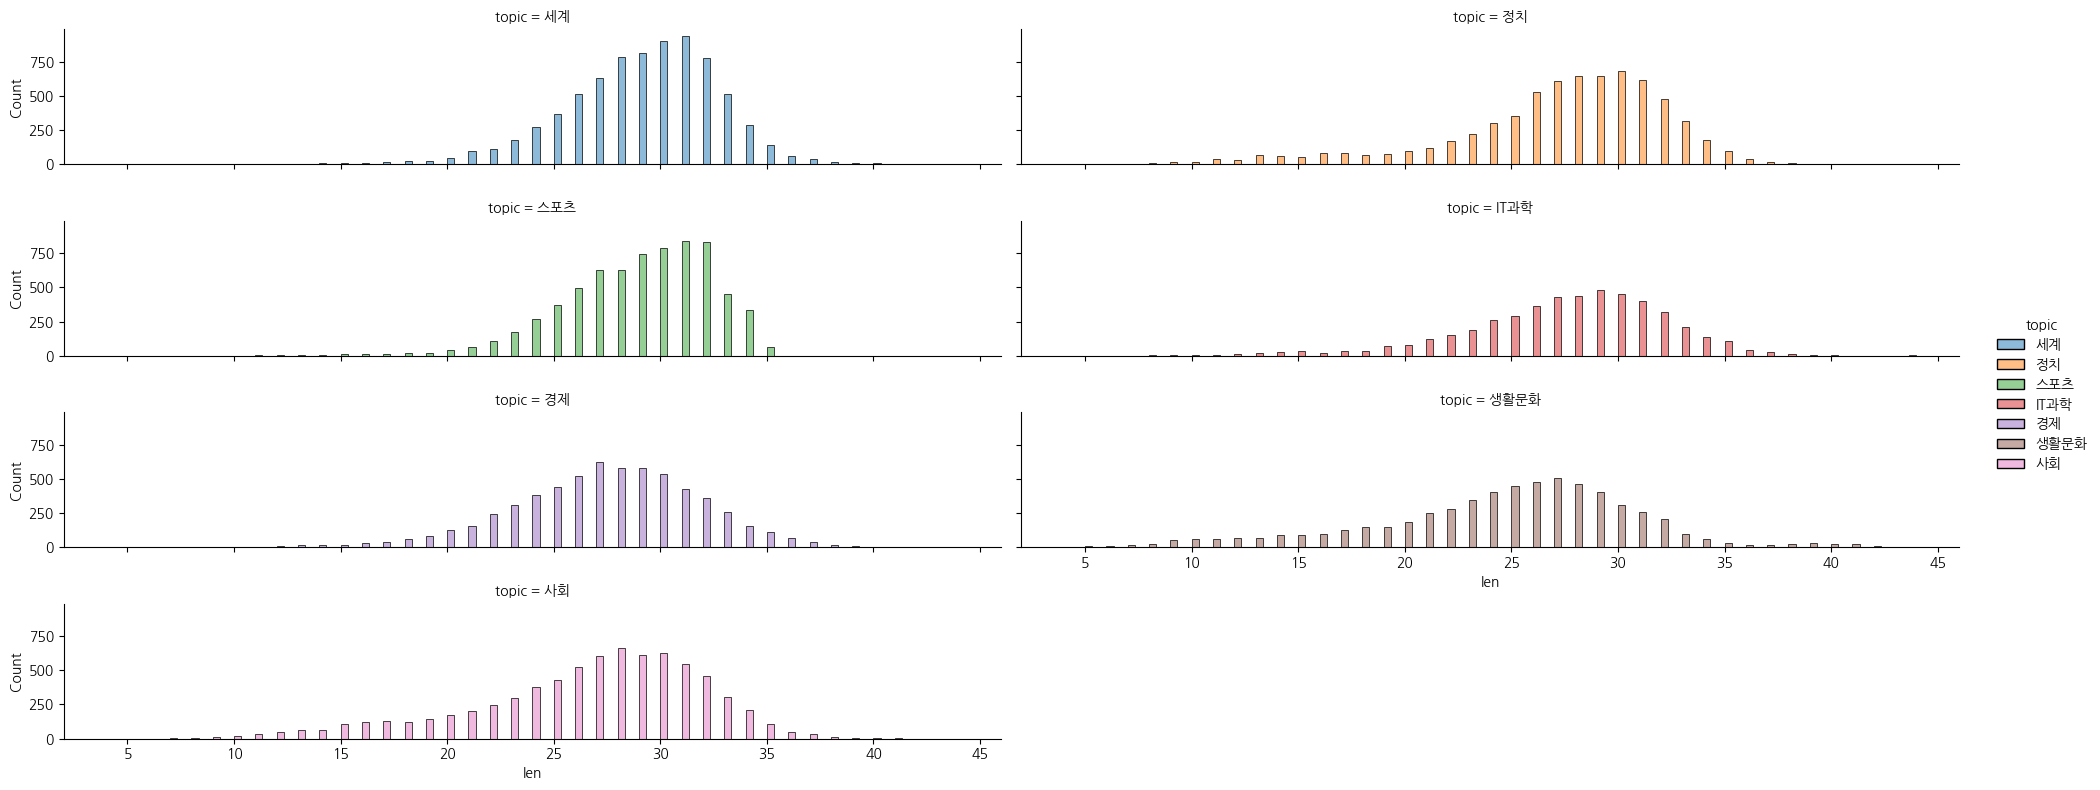

In [ ]:
sns.displot(data=df, x="len", hue="topic", kind="hist", col="topic", col_wrap=2, aspect=5, height=2);

- 토픽별로 단어의 분포수를 보면 IT과학, 생활문화는 y축 값이 다른 주제에 비해 빈도가 적음 ==> 그렇다면 정답값의 빈도수는?

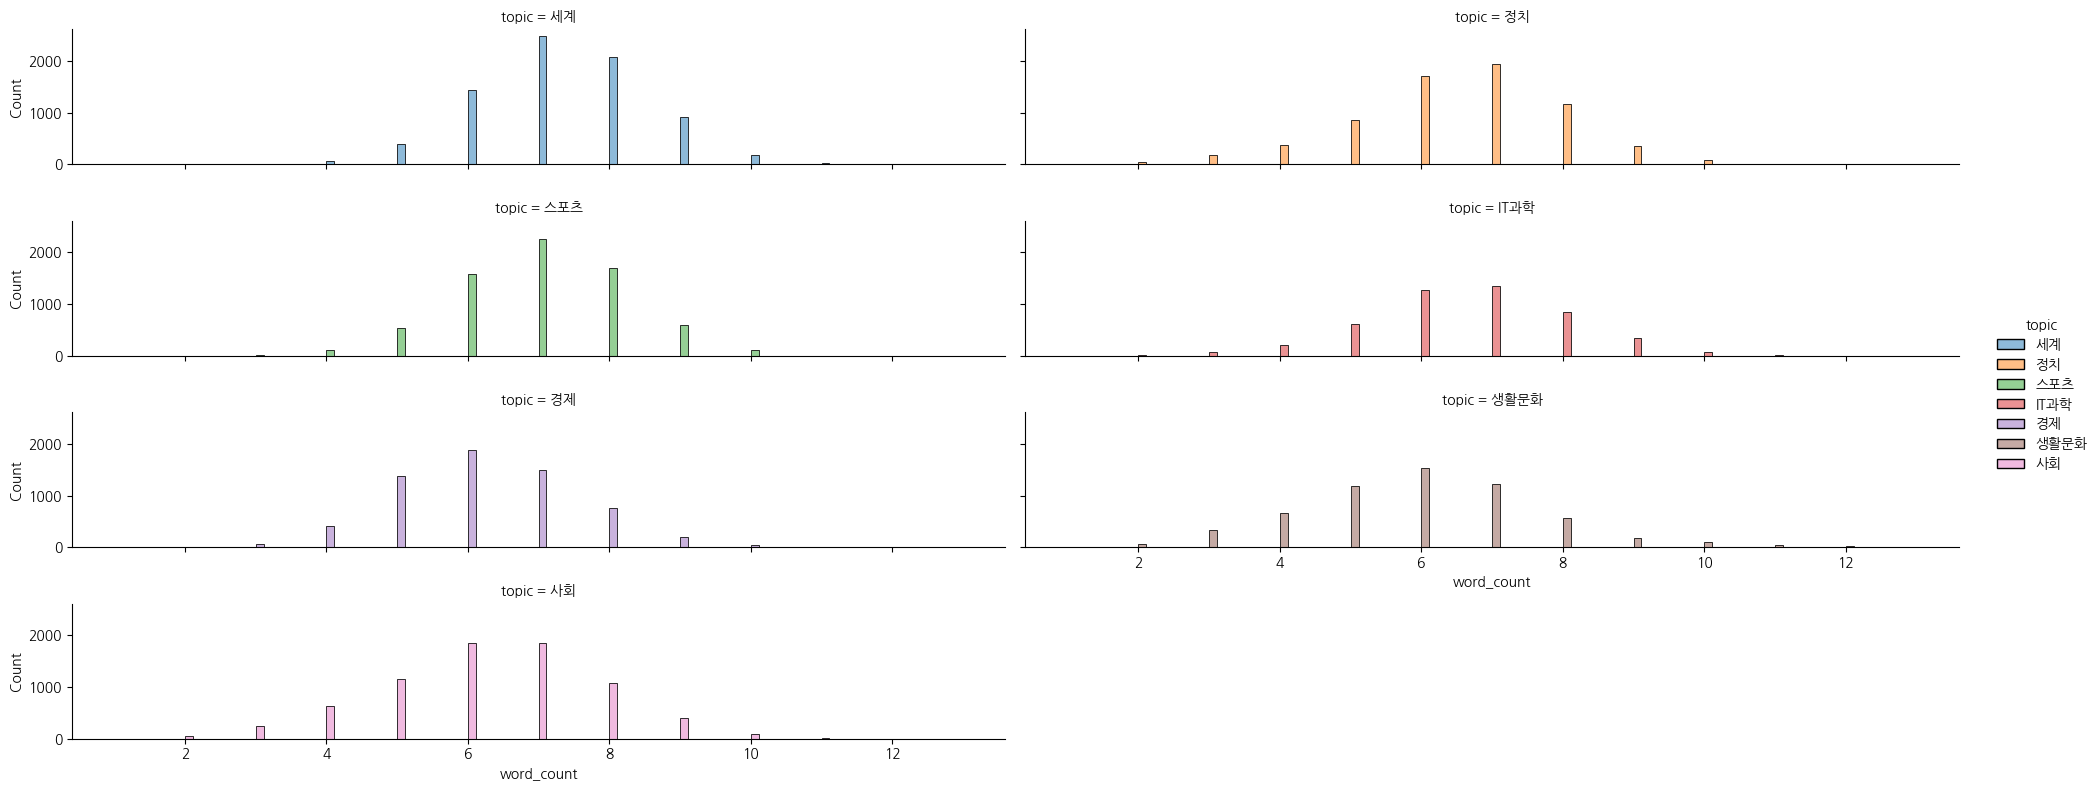

In [ ]:
sns.displot(data=df, x="word_count", hue="topic", kind="hist", col="topic", col_wrap=2, aspect=5, height=2);

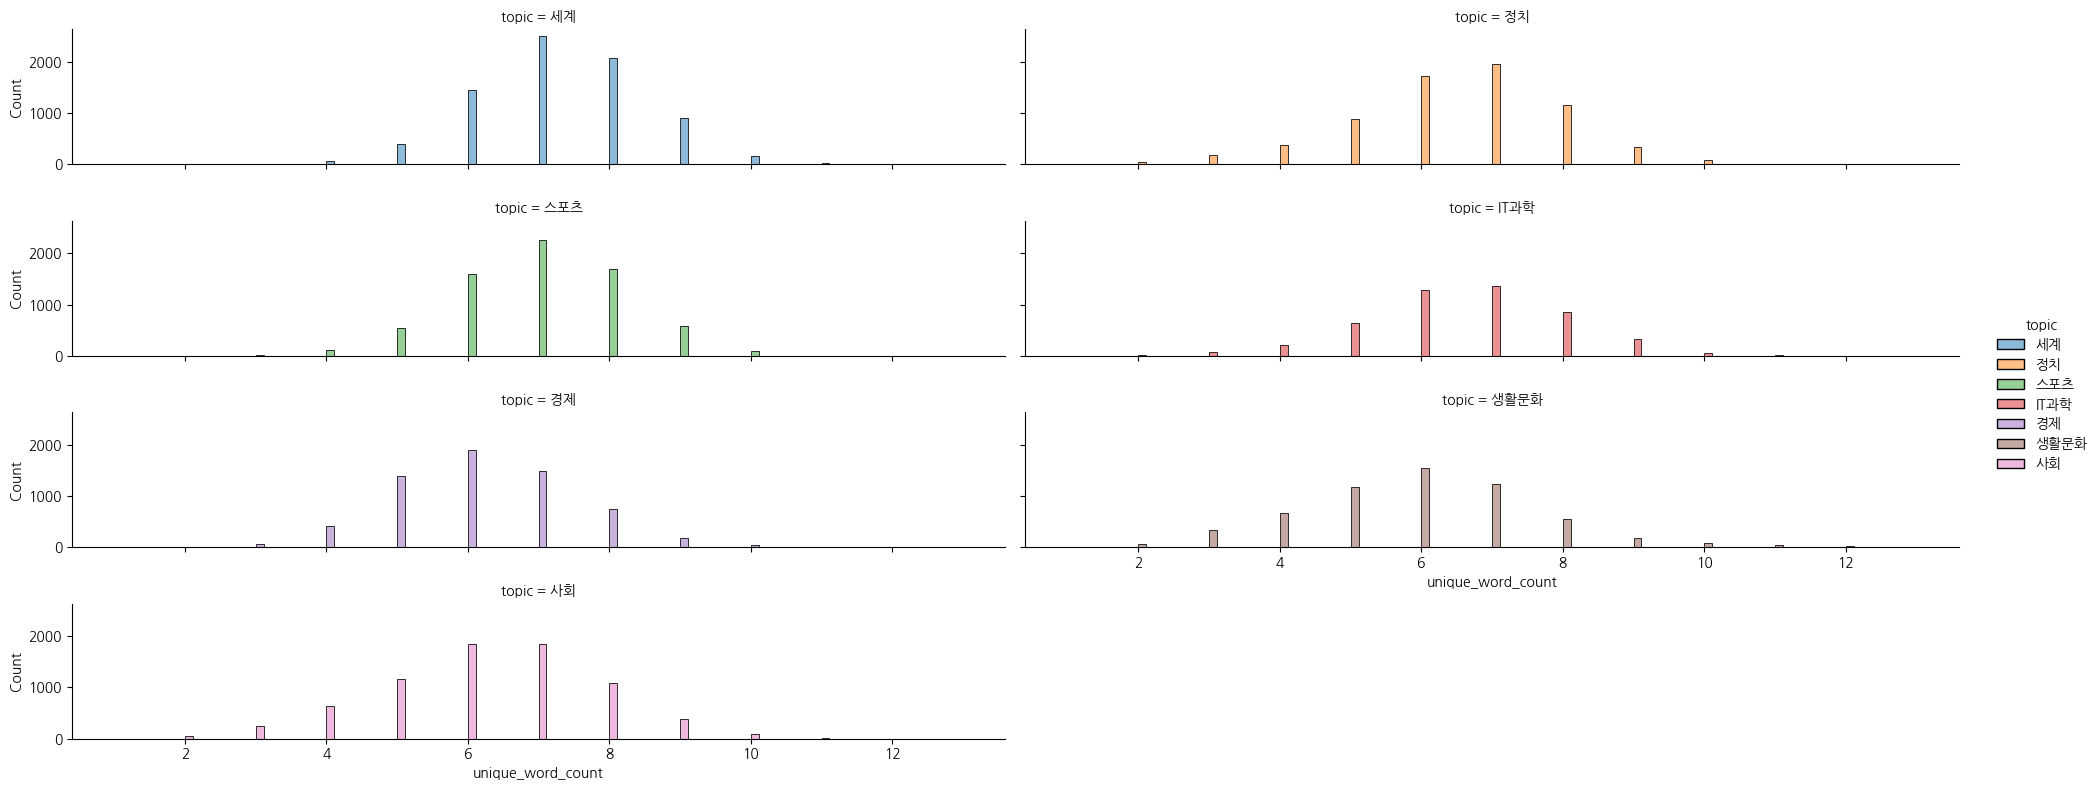

In [ ]:
sns.displot(data=df, x="unique_word_count", hue="topic", kind="hist", col="topic", col_wrap=2, aspect=5, height=2);

### 2) 문자 전처리
- 단어의 띄어쓰기 기준으로 벡터화 -> 대소문자에 따라 중복된 단어 사전 생성 됨
- 과적합 발생 ==> 모델 성능 약화
- 문자 전처리 필요(숫자 제거 여부, 영문자 통일, 조사, 어미, 구둣점 제거)

#### 숫자 제거

0                인천→핀란드 항공기 결항…휴가철 여행객 분통
1          실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
2          이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3        NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4               시진핑 트럼프에 중미 무역협상 조속 타결 희망
                       ...               
54780        인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여
54781       노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
54782        40년 전 부마항쟁 부산 시위 사진 2점 최초 공개
54783       게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계
54784     유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구
Name: title, Length: 54785, dtype: object

#### 영문자 소문자 변경


#### 한글, 영문과 공백만 남기고 제거

0            인천 핀란드 항공기 결항 휴가철 여행객 분통
1        실리콘밸리 넘어서겠다 구글 조원 들여  전역 거점화
2      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3        클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4           시진핑 트럼프에 중미 무역협상 조속 타결 희망
Name: title_han, dtype: object

#### 공백 여러 개는 하나로

'공백 전처리'

0               인천 핀란드 항공기 결항 휴가철 여행객 분통
1            실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2         이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3           클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4              시진핑 트럼프에 중미 무역협상 조속 타결 희망
                      ...               
54780                인천 오후 시분 대설주의보 눈 쌓여
54781      노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
54782          년 전 부마항쟁 부산 시위 사진 점 최초 공개
54783        게시판 아리랑 아프리카개발은행 총회 개회식 생중계
54784    유영민 과기장관 강소특구는 지역 혁신의 중심 지원책 강구
Name: title_han, Length: 54785, dtype: object

#### 불용어 제거

['나는', '밥을', '먹는다']

['밥을', '먹는다']


['밥을', '먹고', '라면을', '먹었다']


'밥을 먹고 라면을 먹었다'

0                인천→핀란드 항공기 결항…휴가철 여행객 분통
1            실리콘밸리 넘어서겠다…구글 조원 들여 美전역 거점화
2            이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는
3        NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4               시진핑 트럼프에 중미 무역협상 조속 타결 희망
                       ...               
54780             인천 오후 시분 대설주의보…눈 .cm 쌓여
54781       노래방에서 지인 성추행 외교부 사무관 불구속 입건종합
54782           년 전 부마항쟁 부산 시위 사진 점 최초 공개
54783       게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계
54784     유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구
Name: title, Length: 54785, dtype: object

## 형태소 분석을 통한 조사, 구두점 제거
* Pecab
    * [Pecab: Pure python Korean morpheme analyzer based on Mecab (https://github.com/hyunwoongko/pecab)
    
* [형태소 분석 및 품사 태깅 — KoNLPy 0.6.0 documentation](https://konlpy.org/ko/v0.6.0/morph/)
* [Korean POS tags comparison chart - Google Sheets](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)

CPU times: user 24.6 ms, sys: 923 µs, total: 25.5 ms
Wall time: 71.3 ms


[('아버지', 'NNG'),
 ('가', 'JKS'),
 ('방', 'NNG'),
 ('에', 'JKB'),
 ('들어가', 'VV'),
 ('신다', 'EP+EC')]

배민 NNG
  SP
피자 NNG
  SP
치킨 NNG
  SP
시켰 VV+EP
어요 EF


'배민 피자 치킨 시켰어요'

- 에서, 와, 을, . 빠진걸 볼 수 있음

100%|██████████| 45654/45654 [16:38<00:00, 45.74it/s]


In [ ]:
train.head()

,index,title,topic_idx,title_remove_pos
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천→핀란드 항공기 결항…휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책 미국 경제전쟁 멈추는 것
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프 중미 무역협상 조속 타결 희망


,index,title,topic_idx,title_remove_pos
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4,인천→핀란드 항공기 결항…휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,이란 외무 긴장완화 해결책 미국 경제전쟁 멈추는 것
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,시진핑 트럼프 중미 무역협상 조속 타결 희망
...,...,...,...,...
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1,KB금융 미국 IB 스티펠 제휴…선진국 시장 공략
45650,45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2,1보 서울시교육청 신종코로나 확산 개학 연기·휴업 검토
45651,45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1,게시판 키움증권 2020 키움 영웅전 실전투자대회
45652,45652,답변하는 배기동 국립중앙박물관장,2,답변하는 배기동 국립중앙박물관장


## 워드 클라우드
- soynlp : 파이썬 만으로 작성된 한국어 분석 도구
  - 비지도학습 지향
  - 신조어 대응

In [ ]:
!apt -qq -y install fonts-nanum
from wordcloud import WordCloud


stopwords = []

def display_word_cloud(data, width=1200, height=500):

    word_draw = WordCloud(
        font_path=r"/Library/Fonts/NanumGothic.ttf",
        width=width, height=height,
        stopwords=stopwords,
        background_color="white",
        random_state=42
    )
    word_draw.generate(data)

    plt.figure(figsize=(15, 7))
    plt.imshow(word_draw)
    plt.axis("off")
    plt.show()

fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


'인천 핀란드 항공기 결항 휴가철 여행객 분통실리콘밸리 넘어서겠다 구글 조원 들여  전역 거점화이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것    클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합시진핑 트럼프에 중미 무역협상 조속 타결 희망팔레스타인 가자지구서 세 소년 이스라엘군 총격에 사망인도 년 만에 파키스탄 공습 테러 캠프 폭격종합보 대선   토론 음담패설 만회실패 트럼프 사과 대신 빌클린턴 공격해 역효과푸틴 한반도 상황 진전 위한 방안 김정은 위원장과 논의특검 면죄부 받은 트럼프 스캔들 보도 언론 맹공 국민의 적  오키나와서 열린 강제징용 노동자 추도식이란서 최고지도자 모욕 혐의 미국인에 징역 년 선고카니발 축제 보러 가자 브라질 리우에 대형 유람선 행렬 올랜도 병원 최악 총기 테러 부상자 치료비 안 받는다  대기업 올해 평균    임금 인상    엘니뇨 여전히 강력 분기엔 소멸될 듯이스라엘 네타냐후 유대교도 병역문제로 연정 협상 진통    사우디 이어   호르무즈 호위 연합에 참여키로사우디군 오만해 유조선 공격 예멘반군과 연결 이란 겨냥개천에서 용 나와라  사업가 모교에 천억원 장학금 기부   브렉시트 합의 전 해야 할 일 많아  에 경고스팍스운용 일본 디플레 벗어나 새로운 도약 준비 중트럼프 총기난사는  의 공격 총기규제 초당적 협력 촉구종합    카지노업체와 스폰서 계약  프로스포츠 사상 처음오바마 대통령 퇴임 후 워싱턴  에 사무실 개소 예정  전문가 트럼프 정부 북한과 정상급 관계 시도할 것이스라엘 네타냐후 이란에 경고 우리 전투기 도달가능 지역이스라엘 네타냐후 총선 한달 앞두고 우크라 방문 예정트럼프 탄핵보고서 통화기록에 등장한 의문의 숫자 미국 산업생산 한달만에     제조업 회복 기대셰이크 살만     회장 평양 방문 최휘 국가체육지도위원장   신중국년  차이나 미라클 최빈국서   경제대국 부상    단교 개월만에 카타르 왕래 화물선 허용송환법 반대 홍콩 집회서 임을 위한 행진곡 울려 퍼져말레이시아 총리 비자금 스캔들 확산 정국

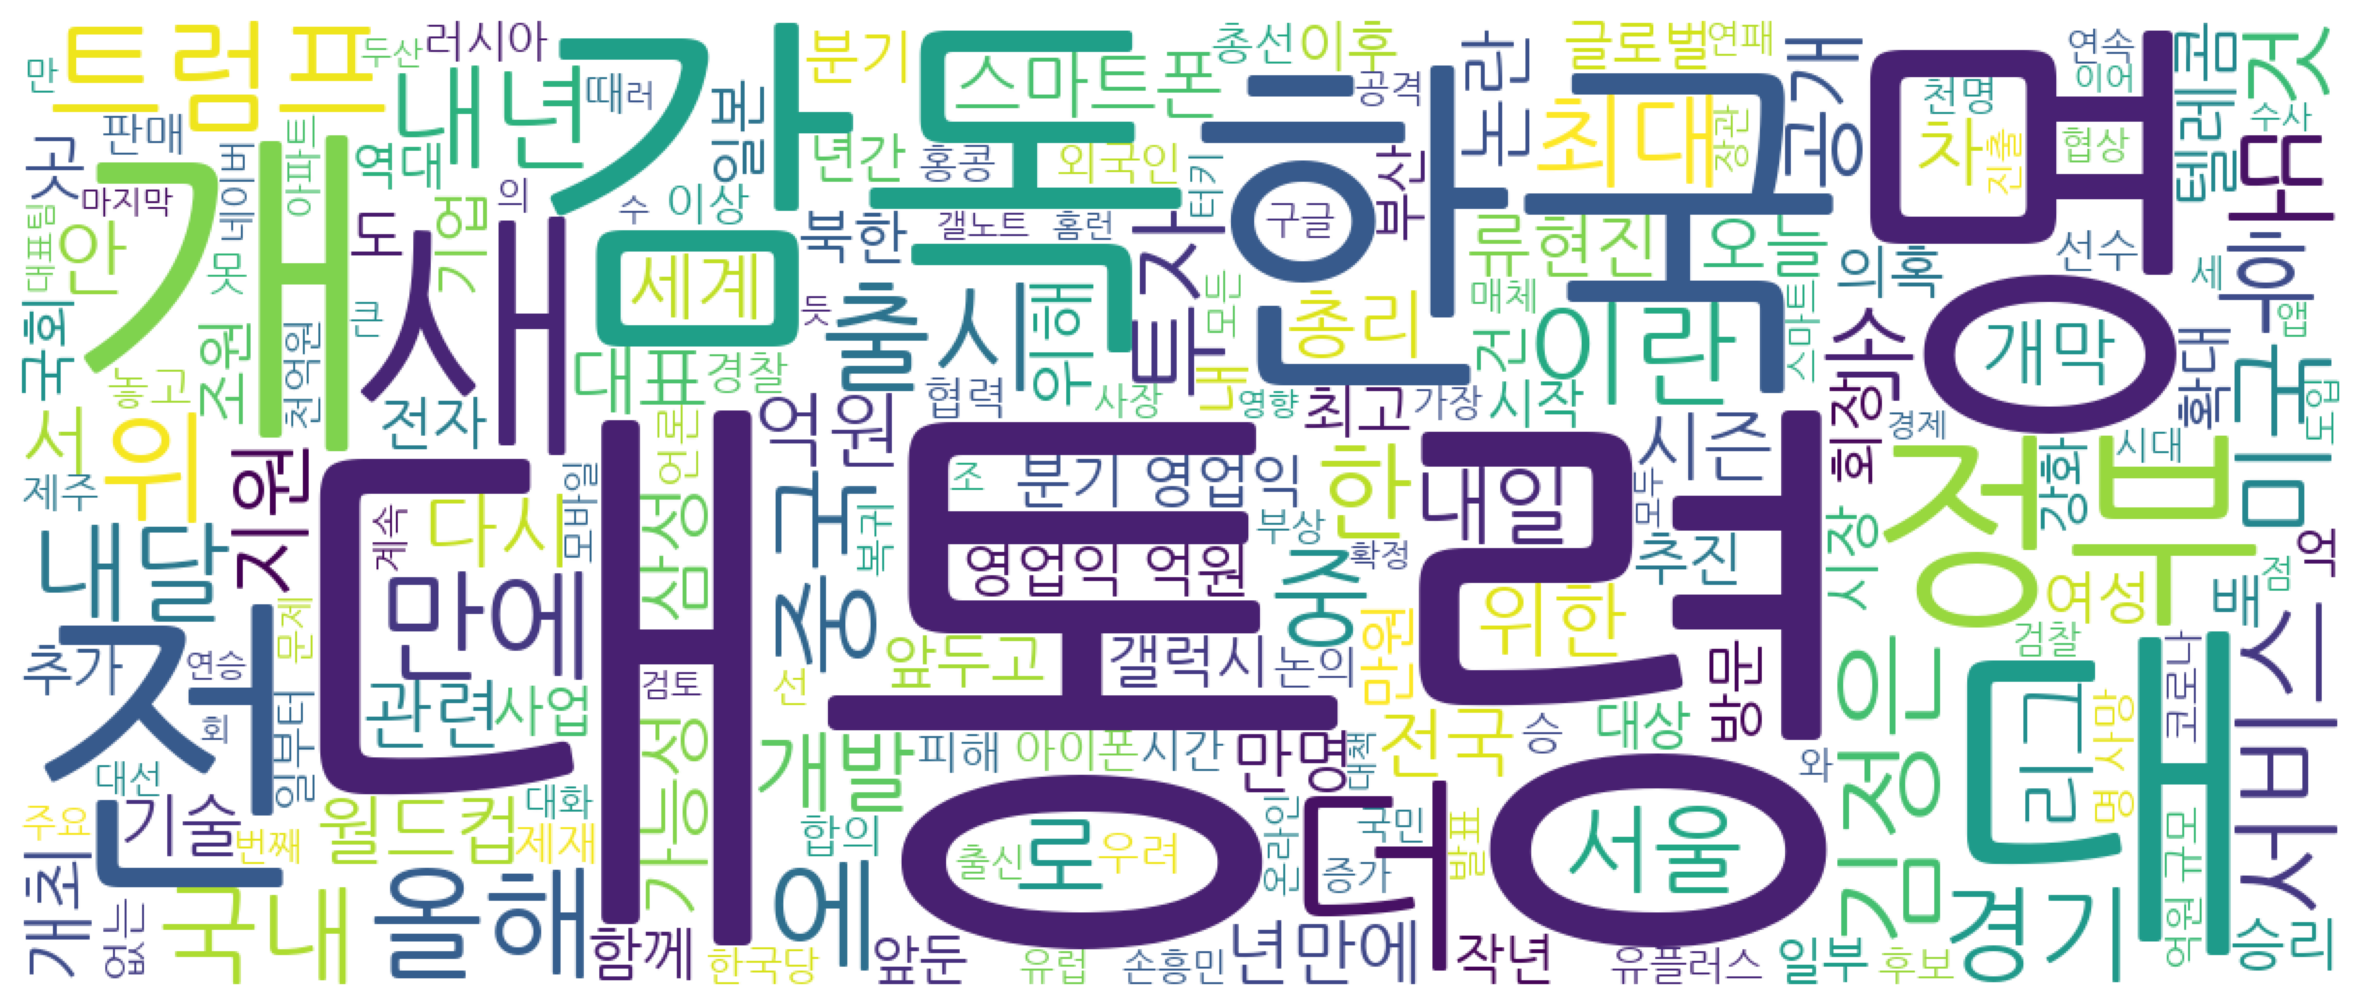

## 특정 토픽 워드 클라우드 시각화

0    IT과학
1      경제
2      사회
3    생활문화
4      세계
5     스포츠
6      정치
Name: topic, dtype: object

,index,title,topic_idx,topic,len,word_count,unique_word_count,title_han
617,617,지카바이러스도 규명한 초저온전자현미경…신약연구에 유용,0.0,IT과학,29,4,4,지카바이러스도 규명한 초저온전자현미경 신약연구에 유용
622,622,증강현실 ① 알파고 이어 포켓몬 고…거센 IT 광풍,0.0,IT과학,28,8,8,증강현실 알파고 이어 포켓몬 고 거센 광풍
643,643,AI 월드컵 생생한 현장 중계도,0.0,IT과학,17,5,5,월드컵 생생한 현장 중계도
654,654,이세돌 알파고 집중력 사람이 이기긴 어렵다 일문일답종합보,0.0,IT과학,32,7,7,이세돌 알파고 집중력 사람이 이기긴 어렵다 일문일답종합보
660,660,올해 휴대폰 국내 생산량 천만대…년전의 .%,0.0,IT과학,33,6,6,올해 휴대폰 국내 생산량 천만대 년전의
...,...,...,...,...,...,...,...,...
45605,45605,화성 적도에서 상당량 수소 발견…물 존재 가능성,0.0,IT과학,26,7,7,화성 적도에서 상당량 수소 발견 물 존재 가능성
45606,45606,갤S 색감 조정하면 된다는 삼성…해외 반응이 관건,0.0,IT과학,28,7,7,갤 색감 조정하면 된다는 삼성 해외 반응이 관건
45613,45613,알코올 중독 유전적 연관성 더 확실해졌다,0.0,IT과학,22,6,6,알코올 중독 유전적 연관성 더 확실해졌다
45619,45619,첫돌 전 아기 배앓이 잦은 까닭은 공생균 결여 때문,0.0,IT과학,28,9,9,첫돌 전 아기 배앓이 잦은 까닭은 공생균 결여 때문


,index,title,topic_idx,topic,len,word_count,unique_word_count,title_han
761,761,못믿을 아파트 관리비…경기 곳서 억 비리 적발종합,1.0,경제,33,7,7,못믿을 아파트 관리비 경기 곳서 억 비리 적발종합
765,765,특징주 관리종목 해제 대우조선해양 강세,1.0,경제,21,5,5,특징주 관리종목 해제 대우조선해양 강세
767,767,특징주 강원랜드 실적 부진에 급락종합,1.0,경제,20,5,5,특징주 강원랜드 실적 부진에 급락종합
769,769,라면 수출 질주…올해 억달러 첫 돌파 확실시,1.0,경제,25,7,7,라면 수출 질주 올해 억달러 첫 돌파 확실시
774,774,경기지표 부진 골드만삭스 한은 금리인상 예상시기 →월로종합,1.0,경제,35,7,7,경기지표 부진 골드만삭스 한은 금리인상 예상시기 월로종합
...,...,...,...,...,...,...,...,...
45620,45620,원달러 환율 보합권 출발…금통위·중국 경제지표 주시,1.0,경제,28,6,6,원달러 환율 보합권 출발 금통위 중국 경제지표 주시
45626,45626,월 가계대출 금리 역대 최저…고작 %대 이자 예금은 최대,1.0,경제,33,9,9,월 가계대출 금리 역대 최저 고작 대 이자 예금은 최대
45629,45629,금융소비자연맹 증권사 안정성 위는 도이치…수익성은 메리츠,1.0,경제,32,6,6,금융소비자연맹 증권사 안정성 위는 도이치 수익성은 메리츠
45649,45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1.0,경제,28,7,7,금융 미국 스티펠과 제휴 선진국 시장 공략


,index,title,topic_idx,topic,len,word_count,unique_word_count,title_han
2458,2458,드라마 제작환경 개선 촉구,2.0,사회,14,4,4,드라마 제작환경 개선 촉구
2460,2460,창원세계사격대회장서 경남 시·군 관광 세계에 알린다종합,2.0,사회,30,6,6,창원세계사격대회장서 경남 시 군 관광 세계에 알린다종합
2465,2465,조배숙 중앙위 정례회의 주재,2.0,사회,15,4,4,조배숙 중앙위 정례회의 주재
2474,2474,인천공항→송도 택시요금 만원…바가지 택시·콜밴,2.0,사회,27,4,4,인천공항 송도 택시요금 만원 바가지 택시 콜밴
2478,2478,조용중 전 연합뉴스 사장 별세,2.0,사회,16,5,5,조용중 전 연합뉴스 사장 별세
...,...,...,...,...,...,...,...,...
45641,45641,창원 시내버스 노조 파업 투표 가결…일 운행 멈춘다종합,2.0,사회,32,8,8,창원 시내버스 노조 파업 투표 가결 일 운행 멈춘다종합
45643,45643,남친과 함께 잔혹하게 동거인 학대 대 여성 구속영장,2.0,사회,30,8,8,남친과 함께 잔혹하게 동거인 학대 대 여성 구속영장
45650,45650,보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2.0,사회,31,7,7,보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토
45652,45652,답변하는 배기동 국립중앙박물관장,2.0,사회,17,3,3,답변하는 배기동 국립중앙박물관장


,index,title,topic_idx,topic,len,word_count,unique_word_count,title_han
953,953,황석영 작가 미국 문학축제서 한국문학 알린다,3.0,생활문화,24,6,6,황석영 작가 미국 문학축제서 한국문학 알린다
960,960,휴일 불청객 울산 미세먼지 주의보 발령,3.0,생활문화,21,6,6,휴일 불청객 울산 미세먼지 주의보 발령
963,963,김수영 신임 한국출판문화산업진흥원장,3.0,생활문화,19,3,3,김수영 신임 한국출판문화산업진흥원장
965,965,신간 한반도평화 오디세이,3.0,생활문화,13,3,3,신간 한반도평화 오디세이
968,968,가극 금강 낭독공연 간담회,3.0,생활문화,19,5,5,가극 금강 낭독공연 간담회
...,...,...,...,...,...,...,...,...
45633,45633,관동팔경 삼척 죽서루에서 풍류 음악회,3.0,생활문화,20,5,5,관동팔경 삼척 죽서루에서 풍류 음악회
45635,45635,한국무용협회 예술대상에 박명숙·김근희·김운미·박재근,3.0,생활문화,28,3,3,한국무용협회 예술대상에 박명숙 김근희 김운미 박재근
45636,45636,기고 아인슈타인 지휘에 맞춰 블랙홀 듀엣 연주가 시작됐다,3.0,생활문화,31,8,8,기고 아인슈타인 지휘에 맞춰 블랙홀 듀엣 연주가 시작됐다
45642,45642,장석주 시인 사랑은 새로운 이야기가 잉태되는 순간,3.0,생활문화,27,7,7,장석주 시인 사랑은 새로운 이야기가 잉태되는 순간


,index,title,topic_idx,topic,len,word_count,unique_word_count,title_han
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계,24,5,5,인천 핀란드 항공기 결항 휴가철 여행객 분통
1,1,실리콘밸리 넘어서겠다…구글 조원 들여 美전역 거점화,4.0,세계,30,6,6,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계,32,7,7,클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7,시진핑 트럼프에 중미 무역협상 조속 타결 희망
...,...,...,...,...,...,...,...,...
45607,45607,독일 항공사 저먼윙스 승무원 연말연시 한시 파업,4.0,세계,26,7,7,독일 항공사 저먼윙스 승무원 연말연시 한시 파업
45618,45618,실사판 옥자 나오나…中 돈육대란에 초대형 돼지 사육 붐,4.0,세계,30,8,8,실사판 옥자 나오나 돈육대란에 초대형 돼지 사육 붐
45623,45623,선거 유세 나선 日 입헌민주당 에다노 대표,4.0,세계,23,7,7,선거 유세 나선 입헌민주당 에다노 대표
45638,45638,日자민당 원로 헌법조는 세계유산…개정 바늘귀만큼도 안돼,4.0,세계,31,6,6,자민당 원로 헌법조는 세계유산 개정 바늘귀만큼도 안돼


,index,title,topic_idx,topic,len,word_count,unique_word_count,title_han
52,52,박찬호 현진이 승 하니깐 생각이 나는데…,5.0,스포츠,24,6,6,박찬호 현진이 승 하니깐 생각이 나는데
54,54,고군분투 시즌 서재덕 MVP 덕큐리로 활짝 웃다종합,5.0,스포츠,28,7,7,고군분투 시즌 서재덕 덕큐리로 활짝 웃다종합
58,58,임도헌 감독 신영석 중심으로 똘똘 뭉쳐 한일전 승리 따냈다,5.0,스포츠,32,9,9,임도헌 감독 신영석 중심으로 똘똘 뭉쳐 한일전 승리 따냈다
63,63,데얀·김치우 OUT 조영욱 IN…서울 과감한 재건 성과...,5.0,스포츠,33,7,7,데얀 김치우 조영욱 서울 과감한 재건 성과
66,66,호날두 노쇼 유벤투스 무책임·거만 비판 수용 어려워,5.0,스포츠,28,7,7,호날두 노쇼 유벤투스 무책임 거만 비판 수용 어려워
...,...,...,...,...,...,...,...,...
45615,45615,프로농구연맹 어시스터 모집,5.0,스포츠,14,3,3,프로농구연맹 어시스터 모집
45625,45625,프로축구 성남 포항서 뛴 브라질 미드필더 무랄랴 영입,5.0,스포츠,29,8,8,프로축구 성남 포항서 뛴 브라질 미드필더 무랄랴 영입
45631,45631,축구 행정가로 년 홍명보 후회 없는 한해였다,5.0,스포츠,25,7,7,축구 행정가로 년 홍명보 후회 없는 한해였다
45634,45634,NBA 미네소타 뎅 영입…팀버울브스 아니고 팀버불스,5.0,스포츠,28,6,6,미네소타 뎅 영입 팀버울브스 아니고 팀버불스


,index,title,topic_idx,topic,len,word_count,unique_word_count,title_han
43,43,김영남 우리 민족 위상 과시…뜨거운 분위기 이어가길,6.0,정치,28,7,7,김영남 우리 민족 위상 과시 뜨거운 분위기 이어가길
48,48,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리,6.0,정치,29,7,7,적극행정 추진전략 및 성과공유대회 참석한 이낙연 총리
49,49,朴대통령 한일 합의에 소녀상 언급없어…선동하면 안돼,6.0,정치,28,6,6,대통령 한일 합의에 소녀상 언급없어 선동하면 안돼
50,50,민주 국회의원 재보선 곳 후보 공모에 명 신청,6.0,정치,27,8,8,민주 국회의원 재보선 곳 후보 공모에 명 신청
53,53,현행 헌법과 다른 점은 ②지방자치·경제민주화 개념 강화,6.0,정치,30,7,7,현행 헌법과 다른 점은 지방자치 경제민주화 개념 강화
...,...,...,...,...,...,...,...,...
45590,45590,박지원 책임있는 위치에 있는 사람들 청문회 증인대 세워야,6.0,정치,31,8,8,박지원 책임있는 위치에 있는 사람들 청문회 증인대 세워야
45603,45603,北 고난의 행군 이어 군자리정신까지…대북제재 효과,6.0,정치,27,6,6,고난의 행군 이어 군자리정신까지 대북제재 효과
45611,45611,北 연이은 도발에 靑 신속·단호 대응…내부선 수위조절 고민도,6.0,정치,33,8,8,연이은 도발에 신속 단호 대응 내부선 수위조절 고민도
45627,45627,정의당 박근혜 역사의 대죄인…징역 년 턱없이 부족,6.0,정치,29,7,7,정의당 박근혜 역사의 대죄인 징역 년 턱없이 부족
